# Project 6 - Voice Cloning and Fake Audio Detection (VCFAD)

**Introduction:**

A technology company working in the Cyber Security industry which focuses on building systems that help individuals and organizations to have safe and secure digital presence requires an algorithm that can synthesize spoken audio by converting a speaker’s voice to another speaker’s voice with the end goal to detect if any spoken audio is pristine or fake.


**Data Description:**

Two datasets will be used in this project:
- **TIMIT Dataset:** The TIMIT corpus of read speech is designed to provide speech data for acoustic-phonetic studies and for the development and evaluation of automatic speech recognition systems. TIMIT contains a total of 6300 sentences, 10 sentences spoken by each of 630 speakers from 8 major dialect regions of the United States.

- **CommonVoice Dataset:** Common Voice is part of Mozilla's initiative to help teach machines how real people speak. Common Voice is a corpus of speech data read by users on the Common Voice website (https://commonvoice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems.


**Goal(s):**

- Build a machine learning system to detect if a spoken audio is synthetically generated or not.

    - First, build a voice cloning system (VC) given a speaker’s spoken audio that clones the source speaker’s voice to the target speaker’s voice. Utilize the TIMIT dataset as it consists of aligned text-audio data with various speakers.
    
    - Next, build a machine learning system which detects if any spoken audio is a natural speech or synthetically generated by machine. Utilize the CommonVoice dataset as it consists of thousands of naturally spoken audio which could be used as golden spoken audio by humans as positive examples and creating negative examples using the voice cloning system as automatic data/label generator. Since the CommonVoice English dataset is large, you can use a subset of it by sampling the dataset.


**Success Metrics:**


- Voice cloning (VC):
    - use Word Error Rate (WER)
    - report speaker classification accuracy
<br><br>
- Fake audio detection (FAD):
    - Use F-score via positive labels coming from the groundtruth dataset and negative labels generated by the VC.

## Voice cloning system (VC)

In [1]:
import numpy as np
import os
import sys
from pathlib import Path
import glob

%load_ext autoreload
%autoreload 2

sys.path.append("Real_Time_Voice_Cloning")

from encoder import inference as encoder
from synthesizer.inference import Synthesizer
from Real_Time_Voice_Cloning.utils.default_models import ensure_default_models
from vocoder import inference as vocoder

import functions

/home/alexandrabinder/Projects/Apziva/P6_Voice_cloning_and_fake_audio_detection/Real_Time_Voice_Cloning/encoder/audio.py:13: UserWarning: Unable to import 'webrtcvad'. This package enables noise removal and is recommended.
  warn("Unable to import 'webrtcvad'. This package enables noise removal and is recommended.")


For the voice cloning system we are going to use the TIMIT dataset which contains a total of 6300 sentences, 10 sentences spoken by each of 630
speakers from 8 major dialect regions of the United States.

### Data preprocessing

In [3]:
!xxd -b ./data/TIMIT/TRAIN/DR1/FCJF0/SA1.WAV | head

00000000: 01001110 01001001 01010011 01010100 01011111 00110001  NIST_1
00000006: 01000001 00001010 00100000 00100000 00100000 00110001  A.   1
0000000c: 00110000 00110010 00110100 00001010 01100100 01100001  024.da
00000012: 01110100 01100001 01100010 01100001 01110011 01100101  tabase
00000018: 01011111 01101001 01100100 00100000 00101101 01110011  _id -s
0000001e: 00110101 00100000 01010100 01001001 01001101 01001001  5 TIMI
00000024: 01010100 00001010 01100100 01100001 01110100 01100001  T.data
0000002a: 01100010 01100001 01110011 01100101 01011111 01110110  base_v
00000030: 01100101 01110010 01110011 01101001 01101111 01101110  ersion
00000036: 00100000 00101101 01110011 00110011 00100000 00110001   -s3 1
xxd: Broken pipe


Since files start with a NIST_1 header instead of a RIFF header, we have to convert them to a proper .wav format to be able to use de sound_recognition functions.

In [45]:
ORIGINAL_AUDIOFILES_PATH = "data/TIMIT/TRAIN"
functions.convert_audiofiles(ORIGINAL_AUDIOFILES_PATH)

Extract .wav files from the original folder and organize them in a new one.

In [107]:
ORIGINAL_WAV_PATH = 'data/data_wav/original'
FAKE_WAV_PATH = 'data/data_wav/fake'
TXT_PATH = 'data/data_txt'

In [46]:
if not os.path.exists(ORIGINAL_WAV_PATH): os.makedirs(ORIGINAL_WAV_PATH)
if not os.path.exists(FAKE_WAV_PATH): os.makedirs(FAKE_WAV_PATH)
if not os.path.exists(TXT_PATH): os.makedirs(TXT_PATH)

functions.organize_audio_files(root_path='data/TIMIT/TRAIN', new_wav_folder=ORIGINAL_WAV_PATH, new_txt_folder=TXT_PATH)

### Voice cloning process

I will be using the functions from the following github:
`https://github.com/CorentinJ/Real-Time-Voice-Cloning.git`

In [7]:
functions.check_cuda()

Found 1 GPUs available. Using GPU 0 (NVIDIA GeForce RTX 3060 Laptop GPU) of compute capability 8.6 with 6.2Gb total memory.



In [32]:
## Load the models one by one.
ensure_default_models(Path("saved_models"));
encoder.load_model(Path("saved_models/default/encoder.pt"));
synthesizer = Synthesizer("saved_models/default/synthesizer.pt");
vocoder.load_model(Path("saved_models/default/vocoder.pt"));

Loaded encoder "encoder.pt" trained to step 1564501
Synthesizer using device: cuda
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at saved_models/default/vocoder.pt


In [114]:
original_voice_files = glob.glob(os.path.join(ORIGINAL_WAV_PATH, "*"))
wer_list = []
for i, path in enumerate(original_voice_files):
    text_file = os.path.join(TXT_PATH, path.split('/')[-1].split('.')[0]+'.TXT')
    print(text_file)
    
    break

data/data_txt/DR4_MSTF0_SA2.TXT
Don't ask me to carry an oily rag like that.



In [ ]:
original_voice_files = glob.glob(os.path.join(ORIGINAL_WAV_PATH, "*"))
wer_list = []
for i, path in enumerate(original_voice_files):
    try:
        src_audio = path
        if i < len(original_voice_files)-1: sample_audio = original_voice_files[i+1]
        else: sample_audio = original_voice_files[0] 
        dst_audio = os.path.join(FAKE_WAV_PATH, "fake_" + src_audio.split('/')[-1])
        wer = functions.voice_cloning(src_audio=src_audio, 
                                    src_text_file=os.path.join(TXT_PATH, path.split('/')[-1].split('.')[0]+'.TXT'),
                                    sample_voice=sample_audio, 
                                    dst_audio=dst_audio)
        wer_list.append(wer)
    
    except Exception as e:
        print("Caught exception: %s" % repr(e))

In [126]:
np.mean(wer_list)

0.6849088794752772

## Fake Audio Detection (FAD)

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

ORIGINAL_WAV_PATH = 'data/data_wav/original'
FAKE_WAV_PATH = 'data/data_wav/fake'
PICKLE_FILE = 'data/data_for_classification_model.pkl'

In [15]:
original_files, X_neg, y_neg = functions.calculate_MFCCs_and_labels(files_path=ORIGINAL_WAV_PATH, y_value=0)
fake_files, X_pos, y_pos = functions.calculate_MFCCs_and_labels(files_path=FAKE_WAV_PATH, y_value=1)

files_to_save = {
    "negative": {"files": original_files,   "X": X_neg,     "y": y_neg},
    "positive": {"files": fake_files,       "X": X_pos,     "y": y_pos}
}

with open(PICKLE_FILE, 'wb') as f:
    pickle.dump(files_to_save, f)
f.close()

In [4]:
with open(PICKLE_FILE, 'rb') as f:
    data = pickle.load(f)

In [5]:
X = data['negative']['X'] + data['positive']['X']
y = data['negative']['y'] + data['positive']['y']

MFCCs (mel-frequency cepstral coefficients) are a powerful representation of the short-term power spectrum of a sound. Plotting the MFCC can be an important tool for analyzing and understanding audio signals, as it can provide a visual representation of the frequency content of the sound. This can be particularly useful in tasks such as audio compression, where it is important to reduce transmission bandwidth and storage requirements without sacrificing too much quality.

/home/alexandrabinder/anaconda3/envs/apziva-p1/lib/python3.10/site-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


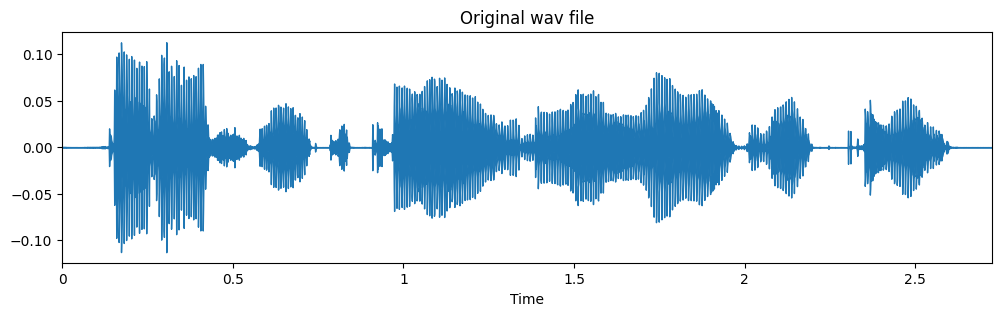

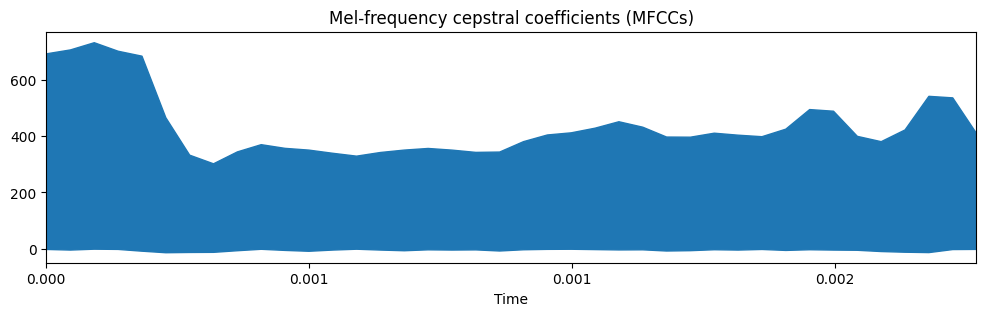

In [6]:
data_example, sampling_rate = librosa.load(os.path.join(ORIGINAL_WAV_PATH, data['negative']['files'][0]))

fig1 = plt.figure(figsize=(12, 3));
fig1 = librosa.display.waveplot(data_example, sr=sampling_rate);
fig1 = plt.title('Original wav file');

fig2 = plt.figure(figsize=(12, 3));
fig2 = librosa.display.waveplot(X[0]);
fig2 = plt.title('Mel-frequency cepstral coefficients (MFCCs)');

In [76]:
X_train, X_val, X_test, y_train, y_val, y_test = functions.get_train_test_split(X, y, test_size=0.2, val_size=0.25)
print(f'X_train: {X_train.shape}\ty_train: {y_train.shape}')
print(f'X_val: {X_val.shape}\ty_val: {y_val.shape}')
print(f'X_test: {X_test.shape}\ty_test: {y_test.shape}')

X_train: (4090, 20, 40, 1)	y_train: (4090,)
X_val: (1364, 20, 40, 1)	y_val: (1364,)
X_test: (1364, 20, 40, 1)	y_test: (1364,)


In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Disable GPU growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], False)

2023-04-24 21:01:10.485986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 21:01:11.472161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-24 21:01:13.835312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-24 21:01:13.835379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: abinder
2023-04-24 21:01:13.835395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: abinder
2023-04-24 21:01:13.835583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda report

In [87]:
model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(20, 40, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=1e-6)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/10
128/128 [==============================] - 6s 42ms/step - loss: 0.6864 - accuracy: 0.7689 - val_loss: 0.2958 - val_accuracy: 0.9069
Epoch 2/10
128/128 [==============================] - 5s 42ms/step - loss: 0.1989 - accuracy: 0.9440 - val_loss: 0.1572 - val_accuracy: 0.9655
Epoch 3/10
128/128 [==============================] - 5s 42ms/step - loss: 0.1276 - accuracy: 0.9773 - val_loss: 0.1179 - val_accuracy: 0.9824
Epoch 4/10
128/128 [==============================] - 5s 41ms/step - loss: 0.1024 - accuracy: 0.9895 - val_loss: 0.0995 - val_accuracy: 0.9897
Epoch 5/10
128/128 [==============================] - 5s 41ms/step - loss: 0.0898 - accuracy: 0.9939 - val_loss: 0.0886 - val_accuracy: 0.9934
Epoch 6/10
128/128 [==============================] - 5s 42ms/step - loss: 0.0818 - accuracy: 0.9963 - val_loss: 0.0821 - val_accuracy: 0.9963
Epoch 7/10
128/128 [==============================] - 5s 42ms/step - loss: 0.0767 - accuracy: 0.9980 - val_loss: 0.0773 - val_accuracy: 0.9978

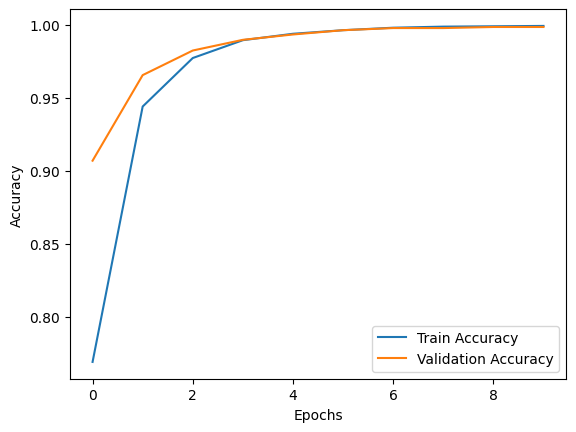

In [88]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

43/43 [==============================] - 0s 9ms/step


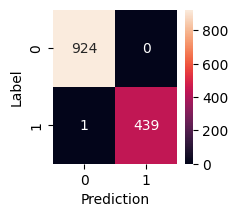

Precision: 0.999266862170088
Recall: 0.999266862170088
F-score: 0.999266862170088


In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

threshold = 0.6
y_pred = model.predict(X_test)
y_pred = (y_pred > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2,2))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

prfs = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(f'Precision: {prfs[0]}\nRecall: {prfs[1]}\nF-score: {prfs[2]}')